# Logistic Regression for Stacking

This notebook trains the logistic regression classifier on the outputs of the three learners (Bernoulli Naive Bayes, LSTM, mBERT).

## Google Colab Setup

We install the necessary libraries and mount the Google Drive where the datasets and models are stored.

In [ ]:
import subprocess

# Installation on Google Colab
try:
  import google.colab
  subprocess.run(['python', '-m', 'pip', 'install',  'transformers', 'joblib', 'calamanCy'])
except ImportError:
  pass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import torch
from torch import nn
import joblib
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from torch import Tensor
import calamancy
from transformers import (
  BertForSequenceClassification,
  BertTokenizer
)
from torch import Tensor, LongTensor
import os
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Settings

In [ ]:
# Locate the root directory where the trained Bernoulli Naive Bayes, LSTM, and
# mBERT models were saved
MODELS_FOLDER = '/content/drive/MyDrive/School/Thesis - Hate Speech/Models/100-revised-1'

# Use the GPU if available
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

Set the hyperparameters used for each learner. Note that this must be the same as what they were trained with.

#### LSTM

In [ ]:
HIDDEN_SIZE = 50

#### mBERT

In [ ]:
BERT_MAX_LENGTH = 250

## Bernoulli Naive Bayes

### Loading TF-IDF

In [ ]:
try:
  tfidf = joblib.load(f'{MODELS_FOLDER}/model_bayes/best/tfidf.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Loading Bernoulli Naive Bayes

In [ ]:
try:
  BayesModel = joblib.load(f'{MODELS_FOLDER}/model_bayes/best/bayes.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator BernoulliNB from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Prediction Functions

To get the predictions for Bernoulli Naive Bayes, we vectorize the input using TF-IDF and use that as the input to the model itself.

In [ ]:
def predict_bayes(inputs: list):
  inputs_transformed = tfidf.transform(inputs)
  predictions = BayesModel.predict(inputs_transformed)
  return predictions

def predict_proba_bayes(inputs: list):
  inputs_transformed = tfidf.transform(inputs)
  predictions = BayesModel.predict_proba(inputs_transformed)
  return predictions

## LSTM

### Loading CalamanCy

In [ ]:
Calamancy = calamancy.load("tl_calamancy_md-0.1.0")

Calamancy

ℹ Installing 'tl_calamancy_md-0.1.0' from
https://huggingface.co/ljvmiranda921/tl_calamancy_md/resolve/main/tl_calamancy_md-any-py3-none-any.whl...


/usr/local/lib/python3.10/dist-packages/spacy/util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn_msg)


#### CalamanCy Functions

These are used to tokenize and vectorize the inputs to LSTM.

In [ ]:
def get_calamancy_tokens(data):
  # Allows it to work with both dataframes and
  # simple lists of strings
  if isinstance(data, pd.Series):
    data = data.values

  data = [text.lower() for text in data]

  samples = []

  for sample in Calamancy.pipe(data):
    tokens = []

    for token in sample:
      if token.is_punct: continue
      if token.is_space: continue

      tokens.append(token)

    samples.append(tokens)

  return samples

def get_token_vectors(tokens):
  vectors = []

  for sample in tokens:
    token_vectors = []
    # Check in case empty due to processing
    if not sample:
      token_vectors.append(np.zeros((200)))
    else:
      for token in sample:
        if token.has_vector:
          token_vectors.append(token.vector)
    token_vectors = Tensor(np.array(token_vectors))

    vectors.append(token_vectors)

  return vectors

### Loading LSTM

We must initialize LSTM using the hyperparameters it was first set with, particularly the hidden size; input and output size remain the same. Then we load the parameters obtained from training.

In [ ]:
INPUT_SIZE = 200
OUTPUT_SIZE = 2

class LstmModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(
      INPUT_SIZE,
      HIDDEN_SIZE,
    )
    self.linear = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)

  def forward(self, input):
    lstm_output, _ = self.lstm(input)

    linear_output = self.linear(lstm_output[-1])

    return linear_output

Lstm = LstmModel()
Lstm.load_state_dict(
  torch.load(
    f"{MODELS_FOLDER}/model_lstm/best/lstm_checkpoint.pth",
    map_location=DEVICE,
  )['model']
)

Lstm.to(DEVICE)

LstmModel(
  (lstm): LSTM(200, 50)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

### Prediction Functions

To predict for LSTM, first the inputs must be tokenized and vectorized using the CalamanCy functions. Afterwards, they are input to the model to make a prediction.

In [ ]:
# Transform output into probabilities
softmax_function = nn.Softmax(dim=1)

In [ ]:
def process_lstm(inputs: list):
  tokens = get_calamancy_tokens(inputs)
  vectors = get_token_vectors(tokens)
  return vectors

def predict_proba_lstm(inputs: list):
  vectors = process_lstm(inputs)
  preds = []
  for sample in vectors:
    sample = Tensor(sample).to(DEVICE)
    sample_pred = Lstm(sample)
    preds.append(sample_pred)
  preds = torch.stack(preds)
  probabilities = softmax_function(preds)

  return probabilities.cpu()

def predict_lstm(inputs: list):
  probabilities = predict_proba_lstm(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities


## mBERT

In [ ]:
BERT_MODEL_NAME = "bert-base-multilingual-uncased"

### Loading BERT Tokenizer

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained(
  BERT_MODEL_NAME
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

### Loading mBERT

First, we initialize the mBERT model. Then we load the parameters learned during training.

In [ ]:
Bert = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME).to(DEVICE)
Bert.load_state_dict(
  torch.load(
    f"{MODELS_FOLDER}/model_bert/best/bert_checkpoint.pth",
    map_location=DEVICE,
  )['model']
)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

### Prediction Functions

We use the BERT Tokenizer to get the input IDs and attention masks for the text. These are then used by BERT to make predictions.

In [ ]:
def process_bert(inputs):
    input_ids = []
    attention_masks = []

    for text in inputs:
        # Tokenize the text
        tokens = bert_tokenizer.tokenize(text)

        # Truncate the tokens if necessary
        if len(tokens) > BERT_MAX_LENGTH - 2:
            tokens = tokens[:BERT_MAX_LENGTH - 2]

        # Add special tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        # Convert tokens to token IDs
        token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)

        # Pad the token IDs to BERT_MAX_LENGTH
        padding = [0] * (BERT_MAX_LENGTH - len(token_ids))
        token_ids += padding

        # Create attention mask
        attention_mask = [1] * len(tokens) + [0] * len(padding)

        input_ids.append(token_ids)
        attention_masks.append(attention_mask)

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids).to(DEVICE)
    attention_masks = torch.tensor(attention_masks).to(DEVICE)

    return input_ids, attention_masks

# Custom data loader
def data_loader(input_ids, attention_masks, batch_size):
    for i in range(0, len(input_ids), batch_size):
        yield input_ids[i:i+batch_size], attention_masks[i:i+batch_size]

def predict_proba_bert(inputs: list):
  with torch.inference_mode():
    input_ids, attention_masks = process_bert(inputs)

    all_predictions = []
    for batch_input_ids, batch_attention_masks in data_loader(input_ids, attention_masks, 32):
      batch_input_ids = batch_input_ids.to(DEVICE)
      batch_attention_masks = batch_attention_masks.to(DEVICE)

      predictions = Bert(
        batch_input_ids,
        attention_mask=batch_attention_masks,
      ).logits

      probabilities = softmax_function(predictions)

      all_predictions.append(probabilities)

    return torch.cat(all_predictions).cpu()

def predict_bert(inputs: list):
  probabilities = predict_proba_bert(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities

## Ensemble Methods

These functions collectively get the predictions of each learner, be it in the form of only 0 or 1, or probabilities.

`get_learner_predictions` returns an array of the shape $ (3, number\ of \ inputs) $. The three refers to each learner: Bernoulli NB predictions are index 0, LSTM predictions are index 1, and mBERT predictions are index 2. The outputs from each learner are either 0 (non-hate) or 1 (hate).

`get_learner_predictions_proba` likewise returns an array of shape $ (3, number\ of \ inputs, 2) $, where the 2 refers to the probabilities of each prediction being 0 (non-hate) or 1 (hate).


In [ ]:
def get_learner_predictions(inputs: list):
  bayes_pred = predict_bayes(inputs)
  lstm_pred = predict_lstm(inputs)
  bert_pred = predict_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred,
    bert_pred,
  ])

def get_learner_predictions_proba(inputs: list):
  bayes_pred = predict_proba_bayes(inputs)
  lstm_pred = predict_proba_lstm(inputs)
  bert_pred = predict_proba_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred.detach().numpy(),
    bert_pred.detach().numpy(),
  ])

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression

LogisticRegression()

## Dataset

### Loading the dataset

In [ ]:
def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

In [ ]:
dataset_train = read_csv_file('/content/drive/MyDrive/School/Thesis - Hate Speech/Data/dataset-train.csv')
dataset_test = read_csv_file('/content/drive/MyDrive/School/Thesis - Hate Speech/Data/dataset-test.csv')

CSV file read successfully!
CSV file read successfully!


### Train Data

In [ ]:
dataset_train

,text,label
0,Matthew Chang [USERNAME] Remind ko lang di ba ...,1
1,Yay! The interview served its purpose wellJess...,0
2,I say DASURV,0
3,TayNew said Let Leni Lead,0
4,Gloc 9 is not endorsing Jejomar Binay as his p...,0
...,...,...
22764,Nov. 11: on [USERNAME] saw tv ads of Jojo Bina...,1
22765,Mar Roxas your call for unity describes one th...,1
22766,Buti nalang nagdecide nakong hindi manood ng T...,0
22767,sang boto para sa pagbabago. Let Leni Lead phi...,0


### Test Data

In [ ]:
dataset_test

,text,label
0,Hindi susuportahan ng theatre and literary est...,0
1,BABAE LABAN SA FAKE AT FRAUDBFFSUMBONGDAYA DES...,1
2,Im proud to be a Filipino and a kakampink like...,0
3,Grabe noThe hypocrisy of the church to preach ...,1
4,BBMSARAUniteam Ph Arena BBMSARA,0
...,...,...
5687,[USERNAME] Rizalito David is a good man you ca...,0
5688,A very famous religious cult in the Philippine...,1
5689,Tama sir VP Leni Di dapat iboto SI BBM Kase No...,0
5690,RT [USERNAME]: Mar Roxas forever arrogantI can...,1


### Getting X and y from datasets

In [ ]:
X_train = dataset_train['text']
y_train = dataset_train['label']

X_test = dataset_test['text']
y_test = dataset_test['label']

## Training

Get the predicted probabilities from each learner on the train dataset.

In [ ]:
train_predictions = get_learner_predictions_proba(X_train)
train_predictions

array([[[1.20060163e-10, 1.00000000e+00],
        [9.99976993e-01, 2.30071797e-05],
        [6.13182840e-01, 3.86817160e-01],
        ...,
        [3.02543677e-03, 9.96974563e-01],
        [9.99998422e-01, 1.57766116e-06],
        [4.50757903e-05, 9.99954924e-01]],

       [[7.35706603e-03, 9.92642939e-01],
        [9.96262252e-01, 3.73769738e-03],
        [8.27017605e-01, 1.72982469e-01],
        ...,
        [2.07154930e-01, 7.92845130e-01],
        [9.97945249e-01, 2.05477094e-03],
        [2.87943371e-02, 9.71205652e-01]],

       [[5.32126334e-03, 9.94678736e-01],
        [9.98452067e-01, 1.54795614e-03],
        [9.92395401e-01, 7.60466000e-03],
        ...,
        [8.98924887e-01, 1.01075150e-01],
        [9.98504400e-01, 1.49562326e-03],
        [3.28977872e-03, 9.96710181e-01]]])

Get the individual predictions to be used by the model.

In [ ]:
train_individual_predictions = train_predictions[:, :, 1:]
train_individual_predictions

array([[[1.00000000e+00],
        [2.30071797e-05],
        [3.86817160e-01],
        ...,
        [9.96974563e-01],
        [1.57766116e-06],
        [9.99954924e-01]],

       [[9.92642939e-01],
        [3.73769738e-03],
        [1.72982469e-01],
        ...,
        [7.92845130e-01],
        [2.05477094e-03],
        [9.71205652e-01]],

       [[9.94678736e-01],
        [1.54795614e-03],
        [7.60466000e-03],
        ...,
        [1.01075150e-01],
        [1.49562326e-03],
        [9.96710181e-01]]])

Transpose the predictions so each sample of data corresponds to one row, and each column represents one learner: Bernoulli Naive Bayes, LSTM, and mBERT, in that order.

In [ ]:
train_transposed_predictions = train_individual_predictions.T[0]
train_transposed_predictions

array([[1.00000000e+00, 9.92642939e-01, 9.94678736e-01],
       [2.30071797e-05, 3.73769738e-03, 1.54795614e-03],
       [3.86817160e-01, 1.72982469e-01, 7.60466000e-03],
       ...,
       [9.96974563e-01, 7.92845130e-01, 1.01075150e-01],
       [1.57766116e-06, 2.05477094e-03, 1.49562326e-03],
       [9.99954924e-01, 9.71205652e-01, 9.96710181e-01]])

Train the logistic regression.

In [ ]:
logistic_regression.fit(train_transposed_predictions, y_train)
print("Fitted logistic regression")

Fitted logistic regression


## Save Model

Create the directory if it doesn't already exist on drive.

In [ ]:
os.makedirs('/content/drive/MyDrive/School/Thesis - Hate Speech/Models/100-revised-1/model_lr', exist_ok=True)

Save the logistic regression to drive.

In [ ]:
joblib.dump(logistic_regression, f'/content/drive/MyDrive/School/Thesis - Hate Speech/Models/100-revised-1/model_lr/lr.pkl', compress=True)

['/content/drive/MyDrive/School/Thesis - Hate Speech/Models/100-revised-1/model_lr/lr.pkl']

## Results


### Testing


We follow the same procedure as with the train to get the results from the test data.

In [ ]:
test_predictions = get_learner_predictions_proba(X_test)
test_predictions

array([[[9.65663486e-01, 3.43365136e-02],
        [9.99798736e-01, 2.01263968e-04],
        [9.99990184e-01, 9.81570408e-06],
        ...,
        [9.56632428e-01, 4.33675717e-02],
        [1.00228781e-01, 8.99771219e-01],
        [9.97531920e-01, 2.46807992e-03]],

       [[6.00508749e-01, 3.99491251e-01],
        [1.71253875e-01, 8.28746140e-01],
        [9.83519852e-01, 1.64802056e-02],
        ...,
        [3.61476153e-01, 6.38523817e-01],
        [6.70544058e-02, 9.32945549e-01],
        [9.88704741e-01, 1.12952497e-02]],

       [[3.29119563e-01, 6.70880437e-01],
        [2.85748959e-01, 7.14250982e-01],
        [9.94381011e-01, 5.61896525e-03],
        ...,
        [9.52140272e-01, 4.78596911e-02],
        [6.12661242e-03, 9.93873358e-01],
        [9.97655869e-01, 2.34410213e-03]]])

In [ ]:
test_positive_predictions = test_predictions[:, :, 1:]
test_positive_predictions

array([[[3.43365136e-02],
        [2.01263968e-04],
        [9.81570408e-06],
        ...,
        [4.33675717e-02],
        [8.99771219e-01],
        [2.46807992e-03]],

       [[3.99491251e-01],
        [8.28746140e-01],
        [1.64802056e-02],
        ...,
        [6.38523817e-01],
        [9.32945549e-01],
        [1.12952497e-02]],

       [[6.70880437e-01],
        [7.14250982e-01],
        [5.61896525e-03],
        ...,
        [4.78596911e-02],
        [9.93873358e-01],
        [2.34410213e-03]]])

In [ ]:
test_transposed_predictions = test_positive_predictions.T[0]
test_transposed_predictions

array([[3.43365136e-02, 3.99491251e-01, 6.70880437e-01],
       [2.01263968e-04, 8.28746140e-01, 7.14250982e-01],
       [9.81570408e-06, 1.64802056e-02, 5.61896525e-03],
       ...,
       [4.33675717e-02, 6.38523817e-01, 4.78596911e-02],
       [8.99771219e-01, 9.32945549e-01, 9.93873358e-01],
       [2.46807992e-03, 1.12952497e-02, 2.34410213e-03]])

In [ ]:
y_preds = logistic_regression.predict(test_transposed_predictions)

y_preds

array([1, 1, 0, ..., 0, 1, 0])

## Evaluation Metrics

In [ ]:
accuracy = accuracy_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1: {f1}")

Accuracy: 0.8620871398453971
Recall: 0.8790519344719414
Precision: 0.852027027027027
F1: 0.8653285297649682


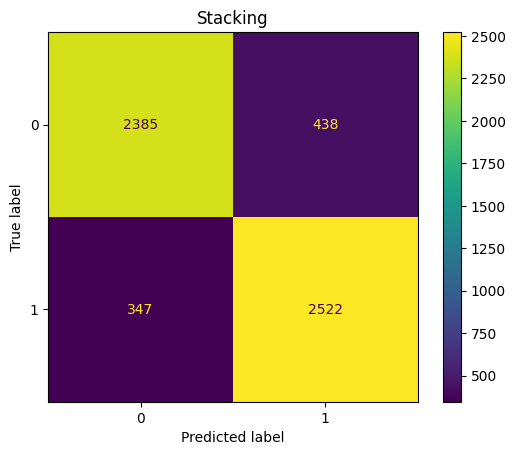

In [ ]:
stacking_conf_matrix = confusion_matrix(y_test, y_preds)

stacking_matrix_display = ConfusionMatrixDisplay(stacking_conf_matrix)

stacking_matrix_display.plot()

plt.title("Stacking")
plt.show()